In [11]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm
import os
import pandas as pd

In [12]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

from market.heston import HestonModel
from market.heston import make_varianceswap_paths
from payoff.european_option import european_call_payoff
from utils.networks import MultiAssetHedgeModel, RecurrentHedgeModel
from optimizer.hedge_train import DeepHedgeCVaRTrainer2Asset, DeepHedgeCVaRTrainer  # or the approach you prefer

In [13]:
# 1) Simulate
heston = HestonModel(
    s0=100.0,     # initial spot
    v0=0.04,      # initial variance
    kappa=1.5,    # mean reversion speed
    theta=0.04,   # long-term variance (mean reversion level)
    xi=0.5,       # vol-of-vol
    rho=-0.7,     # correlation between Brownian shocks
    r=0.0,        # risk-free rate
    dt=1.0/365.0, # daily time step
    # seed=1234     # random seed for reproducibility
)
S_np, V_np = heston.simulate_paths(n_paths=100000, n_steps=30)
vsw_np = make_varianceswap_paths(S_np, V_np, dt=heston.dt)
# shape => (n_paths, n_steps+1)
# stack them to shape => (n_paths, n_steps+1, 2)
market_np = np.stack([S_np, vsw_np], axis=-1)

In [14]:
# 2) Payoff
K=100.0
Z_np = european_call_payoff(S_np, K=K)

# Convert to torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
market_torch = torch.from_numpy(market_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

S_torch = torch.from_numpy(S_np).float().to(device)

In [15]:
alpha = 0.5

num_steps = S_torch.shape[1] - 1

recurrent_model = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

trainer_rec = DeepHedgeCVaRTrainer(
    model=recurrent_model, 
    loss_function="cvar", 
    alpha=alpha
)

import time
start = time.time()
p0_rec = trainer_rec.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=0.0,
    n_epochs=5,
    batch_size=4096
)
end = time.time()
time_rec = end - start

Epoch 1/5 | Loss: 3.5888 | p0: 0.0000
Epoch 2/5 | Loss: 3.5356 | p0: 0.0000
Epoch 3/5 | Loss: 3.5312 | p0: 0.0000
Epoch 4/5 | Loss: 3.5708 | p0: 0.0000
Epoch 5/5 | Loss: 3.5472 | p0: 0.0000


In [16]:
# Evaluate model performance (no gradient computation needed)
with torch.no_grad():
    deltas_rec = recurrent_model(S_torch)
    Sdiff = S_torch[:, 1:] - S_torch[:, :-1]  
    gains_rec = torch.sum(deltas_rec * Sdiff, dim=1)
    pnl_rec = (trainer_rec.p0 - Z_torch + gains_rec).cpu().numpy()

In [17]:
# 3) Build multi-asset net & train
model_ma = MultiAssetHedgeModel(steps=num_steps, in_dim=4, hidden_dim=32, out_dim=2).to(device)
trainer_ma = DeepHedgeCVaRTrainer2Asset(model_ma, alpha=0.5, lr=1e-3)

start = time.time()
p0 = trainer_ma.train(market_torch, Z_torch, p0_init=0.0, n_epochs=5, batch_size=2048)
end = time.time()
time_ma = end - start
print("Learned hedge cost p0 =", p0)

Learned hedge cost p0 = 0.24500036239624023


In [18]:
# Evaluate final distribution
with torch.no_grad():
    deltas = model_ma(market_torch)
    # compute final PnL
    from optimizer.hedge_train import compute_2instrument_pnl
    pnl_torch = compute_2instrument_pnl(trainer_ma.p0, Z_torch, deltas, market_torch)
pnl_np = pnl_torch.cpu().numpy()

In [19]:
import pandas as pd
import numpy as np

def compute_cvar(pnl, alpha):
    """
    Computes empirical CVaR at the given alpha level.
    """
    quantile = np.percentile(pnl, 100 * (1 - alpha))
    cvar = pnl[pnl <= quantile].mean()
    return cvar

# 📊 Compute All Metrics
metrics = {
    "Recurrent Hedge": {
        "Mean PnL": np.mean(pnl_rec),
        "Std PnL": np.std(pnl_rec),
        "MSHE": np.mean(pnl_rec**2),
        "CVaR (0.5)": compute_cvar(pnl_rec, alpha=0.5),
        "CVaR (0.99)": compute_cvar(pnl_rec, alpha=0.99),
        "Price (q)": p0_rec,
    },
    "2-Asset Hedge": {
        "Mean PnL": np.mean(pnl_np),
        "Std PnL": np.std(pnl_np),
        "MSHE": np.mean(pnl_np**2),
        "CVaR (0.5)": compute_cvar(pnl_np, alpha=0.5),
        "CVaR (0.99)": compute_cvar(pnl_np, alpha=0.99),
        "Price (q)": p0,
    }
}

# 🧾 Show in Table
metrics_df = pd.DataFrame(metrics).T
print("\n🔍 Multi-Asset Hedge Comparison:\n")
print(metrics_df.round(4))


🔍 Multi-Asset Hedge Comparison:

                 Mean PnL  Std PnL    MSHE  CVaR (0.5)  CVaR (0.99)  Price (q)
Recurrent Hedge   -2.2438   1.6476  7.7490     -3.5472      -7.9216      0.000
2-Asset Hedge     -1.9847   1.7076  6.8548     -3.3316      -7.7898      0.245


In [20]:
def plot_side_by_side_hist(pnl1, pnl2, label1="Strategy A", label2="Strategy B",
                           bins=20, x_range=(-10, 10), title=None, save_path=None):
    """
    Plot side-by-side histograms for two PnL distributions with aligned bins.
    
    Args:
        pnl1, pnl2: numpy arrays of PnL values.
        label1, label2: labels for the two strategies.
        bins: number of histogram bins (default is 20 for wider bins).
        x_range: tuple, (min, max) for histogram x-axis.
        title: custom plot title. If None, generates one automatically.
        save_path: optional file path to save the plot.
    """
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10, 6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')

    plt.xlabel("Terminal Hedging PnL", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(title or f"Side-by-side PnL Histogram: {label1} vs. {label2}")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

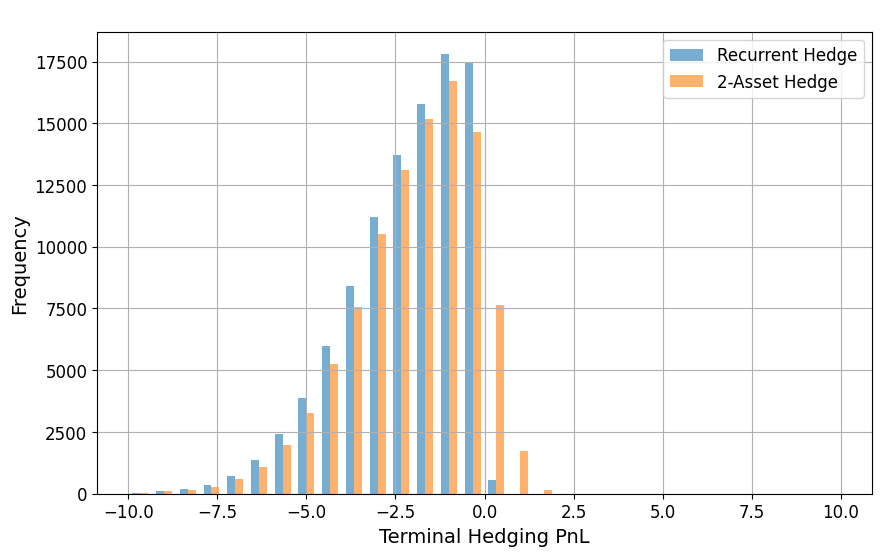

In [21]:
plot_side_by_side_hist(
    pnl1=pnl_rec,
    pnl2=pnl_np,
    label1="Recurrent Hedge",
    label2="2-Asset Hedge",
    bins=30,
    x_range=(-10, 10),
    title=" "
)